<img src="https://miro.medium.com/max/1898/1*w4TIZ1VIu7J2FltbyZ6bYA.png" align='left' />

# Desafio 2 - [Competição Titanic](https://www.kaggle.com/c/titanic/overview)

Nesse desafio vamos trabalhar com uma competição do Kaggle pela primeira vez. O objetivo da competição é criar um modelo que consiga prever quais passageiros morreram e quais sobreviveram no acidente do Titanic.

A comunidade do Kaggle disponibiliza os notebooks com possíveis soluções para a competição. É uma fonte super rica de aprendizado entender as ideias que outras pessoas tiveram e ver as aplicações dessas ideias. Não hesitem em consultar! (Só não vale copiar a solução das pessoas na íntegra hehe)

Abaixo deixamos um passo-a-passo dos macro blocos para nortear vocês! Esse Desafio é uma ótima oportunidade para juntarmos os bloquinhos de Lego e vermos as aplicações de boa parte das técnicas e conceitos vistos até agora! Bora lá!

# 1. Importar libs e carregar os DataFrames

Nas competições do Kaggle é comum recebermos 2 DataFrames. Um de treino e um de teste. Neste caso o DataFrame de **teste** é utilizado apenas para gerar o Score do modelo na competição. Nós realizamos todas as etapas no DataFrame de treino e utilizamos o teste apenas para submeter a solução.

In [53]:
import pandas as pd
import numpy as np

# Data Prep
from feature_engine.categorical_encoders import CountFrequencyCategoricalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from category_encoders import TargetEncoder

# boruta
from boruta import BorutaPy
from pycaret.datasets import get_data
from sklearn.feature_selection import RFECV, f_classif, chi2

# import classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV

# Validação
from sklearn.model_selection import  learning_curve, KFold, LeaveOneOut, cross_validate, validation_curve

# visualização
import seaborn as sns
import matplotlib.pyplot as plt

# modelo
import statsmodels.formula.api as smf
import statsmodels.api as sm

# métricas regressão
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, auc
from sklearn.metrics import classification_report, f1_score, fbeta_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report
# matiz de confusão  
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, log_loss, make_scorer

import warnings
warnings.filterwarnings('ignore')

In [54]:
# Carregando DataFrames
df_raw_train = pd.read_csv('train.csv')
df_final_test = pd.read_csv('test.csv')
df_gender = pd.read_csv('gender_submission.csv')

# 2. Dividir o Dataset de Treino em treino e teste

Conforme vimos nas aulas, antes de começar a trabalhar com os dados, nós separamos uma parte do DataFrame para posterior avaliação do modelo. É importante que o modelo não tenha contato com nenhuma informação deste DataFrame separado para garantir que quando avaliada sobre este DataFrame, a performance do modelo reflita o comportamento do mesmo para dados nunca vistos.

In [55]:
# Fazendo separação em treino e teste, deixando 80% dos dados para treino e 20% para teste
df_train, df_test = train_test_split(df_raw_train, test_size=0.2, random_state=42)

In [56]:
# Verificando o shape de cada um dos dataframes
df_train.shape, df_test.shape, df_final_test.shape

((712, 12), (179, 12), (418, 11))

# 3. Limpeza de Dados

Agora, vamos verificar a consistência dos dados. Hora de identificar e tratar valores nulos, remover linhas e/ou colunas duplicadas, identificar e remover inconsistências nos valores das variáveis (Ex. se houver Fare negativo, não faz sentido), identificar e remover colunas constantes, quase constantes e com baixa variância. (Uma boa dica é voltar lá no Módulo 0 e revisitar a aula de Limpeza de Dados).

In [57]:
# Checando a quantidade de linhas e colunas
print(f'O Conjunto de Dados possui de treino: {df_train.shape[0]} linhas e {df_train.shape[1]} colunas')
print(f'O Conjunto de Dados possui de teste: {df_test.shape[0]} linhas e {df_test.shape[1]} colunas')
print(f'O Conjunto de Dados possui de teste: {df_final_test.shape[0]} linhas e {df_final_test.shape[1]} colunas')

O Conjunto de Dados possui de treino: 712 linhas e 12 colunas
O Conjunto de Dados possui de teste: 179 linhas e 12 colunas
O Conjunto de Dados possui de teste: 418 linhas e 11 colunas


In [58]:
# checando duplicadas nas linhas
print(f'Temos em treino {df_train.duplicated().sum()} linhas duplicadas')
print(f'Temos em teste {df_test.duplicated().sum()} linhas duplicadas')
print(f'Temos em teste {df_final_test.duplicated().sum()} linhas duplicadas')

Temos em treino 0 linhas duplicadas
Temos em teste 0 linhas duplicadas
Temos em teste 0 linhas duplicadas


In [59]:
# checando duplicadas nas colunas
print(f'Temos em treino {df_train.T.duplicated().sum()} colunas duplicadas')
print(f'Temos em teste {df_test.T.duplicated().sum()} colunas duplicadas')
print(f'Temos em teste {df_final_test.T.duplicated().sum()} colunas duplicadas')

Temos em treino 0 colunas duplicadas
Temos em teste 0 colunas duplicadas
Temos em teste 0 colunas duplicadas


In [60]:
# treino e teste tem missing values em Age, Cabin, Embarked
print(df_train.info())
print(df_test.info())
print(df_final_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 331 to 102
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          572 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        159 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 92.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 709 to 10
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  179 non-null    int64  
 1   

In [61]:
# checando missing values
print(f'Missing values treino:\n{df_train.isna().sum()}') # age, cabin, embarked
print(f'\nMissing values teste:\n{df_test.isna().sum()}') # age, cabin
print(f'\nMissing values teste:\n{df_final_test.isna().sum()}') # age, cabin, fare

Missing values treino:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            140
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          553
Embarked         2
dtype: int64

Missing values teste:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             37
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          134
Embarked         0
dtype: int64

Missing values teste:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [62]:
# checando se não há Fare negativo
print(df_train.loc[df_train['Fare']<0].count()[['PassengerId']])
print(df_test.loc[df_test['Fare']<0].count()[['PassengerId']])
print(df_final_test.loc[df_final_test['Fare']<0].count()[['PassengerId']])

PassengerId    0
dtype: int64
PassengerId    0
dtype: int64
PassengerId    0
dtype: int64


In [63]:
# verificar se há algum valor <= 0

print('-----------------------')
print('Treino status')
qtd = 0
cols = ['Age', 'Fare', 'Parch', 'PassengerId', 'Pclass','SibSp', 'Survived']
for col in cols:
    if (df_train[col] < 0).any():
        print(df_train[col])
    else:
        print("Todos valores >= 0 da coluna {}".format(col))

print('-----------------------')
print('Teste status')
qtd = 0
cols = ['Age', 'Fare', 'Parch', 'PassengerId', 'Pclass','SibSp', 'Survived']
for col in cols:
    if (df_test[col] < 0).any():
        print(df_test[col])
    else:
        print("Todos valores >= 0 da coluna {}".format(col))

print('-----------------------')
print('Teste Final status')
qtd = 0
cols = ['Age', 'Fare', 'Parch', 'PassengerId', 'Pclass','SibSp']
for col in cols:
    if (df_final_test[col] < 0).any():
        print(df_final_test[col])
    else:
        print("Todos valores >= 0 da coluna {}".format(col))

-----------------------
Treino status
Todos valores >= 0 da coluna Age
Todos valores >= 0 da coluna Fare
Todos valores >= 0 da coluna Parch
Todos valores >= 0 da coluna PassengerId
Todos valores >= 0 da coluna Pclass
Todos valores >= 0 da coluna SibSp
Todos valores >= 0 da coluna Survived
-----------------------
Teste status
Todos valores >= 0 da coluna Age
Todos valores >= 0 da coluna Fare
Todos valores >= 0 da coluna Parch
Todos valores >= 0 da coluna PassengerId
Todos valores >= 0 da coluna Pclass
Todos valores >= 0 da coluna SibSp
Todos valores >= 0 da coluna Survived
-----------------------
Teste Final status
Todos valores >= 0 da coluna Age
Todos valores >= 0 da coluna Fare
Todos valores >= 0 da coluna Parch
Todos valores >= 0 da coluna PassengerId
Todos valores >= 0 da coluna Pclass
Todos valores >= 0 da coluna SibSp


In [64]:
# checando baixa variância das variáveis int e float
minmax = MinMaxScaler()

# variáveis teste df_train
variaveis_numericas_train = df_train.select_dtypes(include=['int', 'float'])
variaveis_num_escaladas_train = minmax.fit_transform(variaveis_numericas_train)
variaveis_num_escaladas_train = pd.DataFrame(variaveis_num_escaladas_train, columns=variaveis_numericas_train.columns)

# variáveis teste df_test
variaveis_numericas_test = df_test.select_dtypes(include=['int', 'float'])
variaveis_num_escaladas_test = minmax.fit_transform(variaveis_numericas_test)
variaveis_num_escaladas_test = pd.DataFrame(variaveis_num_escaladas_test, columns=variaveis_numericas_test.columns)

# variáveis teste df_test
variaveis_numericas_final_test = df_final_test.select_dtypes(include=['int', 'float'])
variaveis_num_escaladas_final_test = minmax.fit_transform(variaveis_numericas_final_test)
variaveis_num_escaladas_final_test = pd.DataFrame(variaveis_num_escaladas_final_test, \
                                                  columns=variaveis_numericas_final_test.columns)

In [65]:
# variância train
listLowVariance_train = []
for col in variaveis_num_escaladas_train.columns:
    if np.var(variaveis_num_escaladas_train[col]) > 0.001:
        print(f'{col} possui variância considerável')
    else:
        print(f'{col} possui baixa variância')
        listLowVariance.append(col)

Age possui variância considerável
Fare possui variância considerável


In [66]:
# variância test
listLowVariance_test = []
for col in variaveis_num_escaladas_test.columns:
    if np.var(variaveis_num_escaladas_test[col]) > 0.001:
        print(f'{col} possui variância considerável')
    else:
        print(f'{col} possui baixa variância')
        listLowVariance.append(col)

Age possui variância considerável
Fare possui variância considerável


In [67]:
# variância final test
listLowVariance_test = []
for col in variaveis_num_escaladas_test.columns:
    if np.var(variaveis_num_escaladas_test[col]) > 0.001:
        print(f'{col} possui variância considerável')
    else:
        print(f'{col} possui baixa variância')
        listLowVariance.append(col)

Age possui variância considerável
Fare possui variância considerável


# 4. Análise Exploratória de Dados (EDA)

Hora de conhecer os dados! Entender qual é a variável target, o que cada uma das colunas representa, quais as variáveis qualitativas, quais as variáveis quantitativas, observar as distribuições das variáveis e observar relações das variáveis com o target e entre si. Super válido procurar mais informações sobre o Titanic também (maior entendimento do negócio). Como funcionava a venda de passagens? Como as cabines eram distribuídas no navio?

Qual é o tipo de problema que vamos tentar resolver? É um problema de aprendizado supervisionado ou não supervisionado? Regressão ou Classificação?

Trata-se de um problema de Classificação, uma vez que nossa variável target (Survived) é uma variável categórica binária (só assume valor 0 ou 1). Além disso, sabemos se tratar de um problema de aprendizado supervisionado, dado que para treinar nosso modelo conhecemos o label de cada passageiro, isto é se ele sobreviveu ou não.

In [68]:
# Real: 1502 mortos e 722 sobreviventes  

# No dataset treino + teste - 38,4% sobreviventes
passangers = df_train.groupby('Survived').count()[['PassengerId']]+df_test.groupby('Survived').count()[['PassengerId']]
survivers = df_train.loc[df_train['Survived']==1].groupby('Survived').count()[['PassengerId']] / df_train['PassengerId'].count()+\
df_test.loc[df_test['Survived']==1].groupby('Survived').count()[['PassengerId']] / df_test['PassengerId'].count()

print('--------------')
print('Treino')
print(df_train.groupby('Survived').count()[['PassengerId']])
print(df_train.loc[df_train['Survived']==1].groupby('Survived').count()[['PassengerId']] / df_train['PassengerId'].count())

print('--------------')
print('Teste')
print(df_test.groupby('Survived').count()[['PassengerId']])
print(df_test.loc[df_test['Survived']==1].groupby('Survived').count()[['PassengerId']] / df_test['PassengerId'].count())

# lista dos dfs
dfs = [df_train, df_test]

# Junção dos 2 datasets
df_all = pd.concat(dfs, sort=True).reset_index(drop=True)
dfs = [df_all, df_final_test]

df_all_plusTest = pd.concat(dfs, sort=True).reset_index(drop=True)

print('--------------')
print('Geral Treino+Test')
print(df_all.groupby('Survived').count()[['PassengerId']])
print(df_all.loc[df_all['Survived']==1].groupby('Survived').count()[['PassengerId']] / df_all['PassengerId'].count())


--------------
Treino
          PassengerId
Survived             
0                 444
1                 268
          PassengerId
Survived             
1            0.376404
--------------
Teste
          PassengerId
Survived             
0                 105
1                  74
          PassengerId
Survived             
1            0.413408
--------------
Geral Treino+Test
          PassengerId
Survived             
0                 549
1                 342
          PassengerId
Survived             
1            0.383838


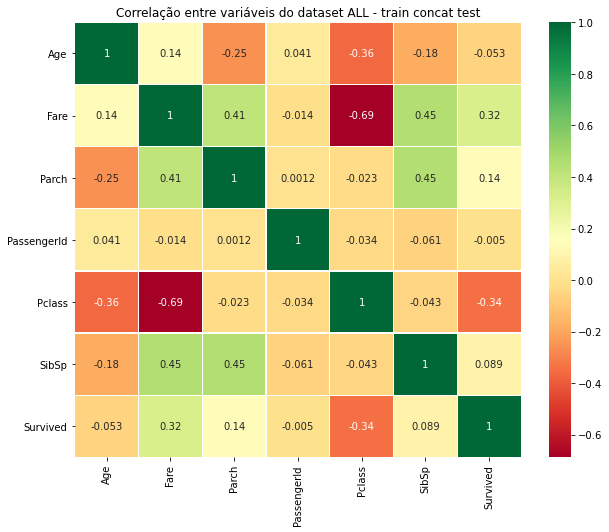

In [69]:
# variáveis não muito correlatas - melhor valor SibSp e Parch / Fare e Survived
sns.heatmap(df_all.corr(method = 'spearman'),annot=True,cmap='RdYlGn',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.title('Correlação entre variáveis do dataset ALL - train concat test')
plt.show()

In [70]:
# dados faltantes treino e teste e seus %

# Treino
print('T R E I N O:\n')

Miss_Train_Value = df_train.isnull().sum().sort_values(ascending=False)
Miss_Train_Perc = df_train.isnull().sum()/df_train.isnull().count()*100

print(Miss_Train_Value.head(3))
print(Miss_Train_Perc.sort_values(ascending=False).head(3))

# Teste

print('\n------')
print('T E S T E:\n')

Miss_Test_Value = df_test.isnull().sum().sort_values(ascending=False)
Miss_Test_Perc = df_test.isnull().sum()/df_test.isnull().count()*100

print(Miss_Test_Value.head(3))
print(Miss_Test_Perc.sort_values(ascending=False).head(3))


# Final Teste

print('\n------')
print('F I N A L  T E S T E:\n')

Miss_Test_Value = df_final_test.isnull().sum().sort_values(ascending=False)
Miss_Test_Perc = df_final_test.isnull().sum()/df_test.isnull().count()*100

print(Miss_Test_Value.head(3))
print(Miss_Test_Perc.sort_values(ascending=False).head(3))


T R E I N O:

Cabin       553
Age         140
Embarked      2
dtype: int64
Cabin       77.668539
Age         19.662921
Embarked     0.280899
dtype: float64

------
T E S T E:

Cabin       134
Age          37
Embarked      0
dtype: int64
Cabin       74.860335
Age         20.670391
Embarked     0.000000
dtype: float64

------
F I N A L  T E S T E:

Cabin    327
Age       86
Fare       1
dtype: int64
Cabin    182.681564
Age       48.044693
Fare       0.558659
dtype: float64


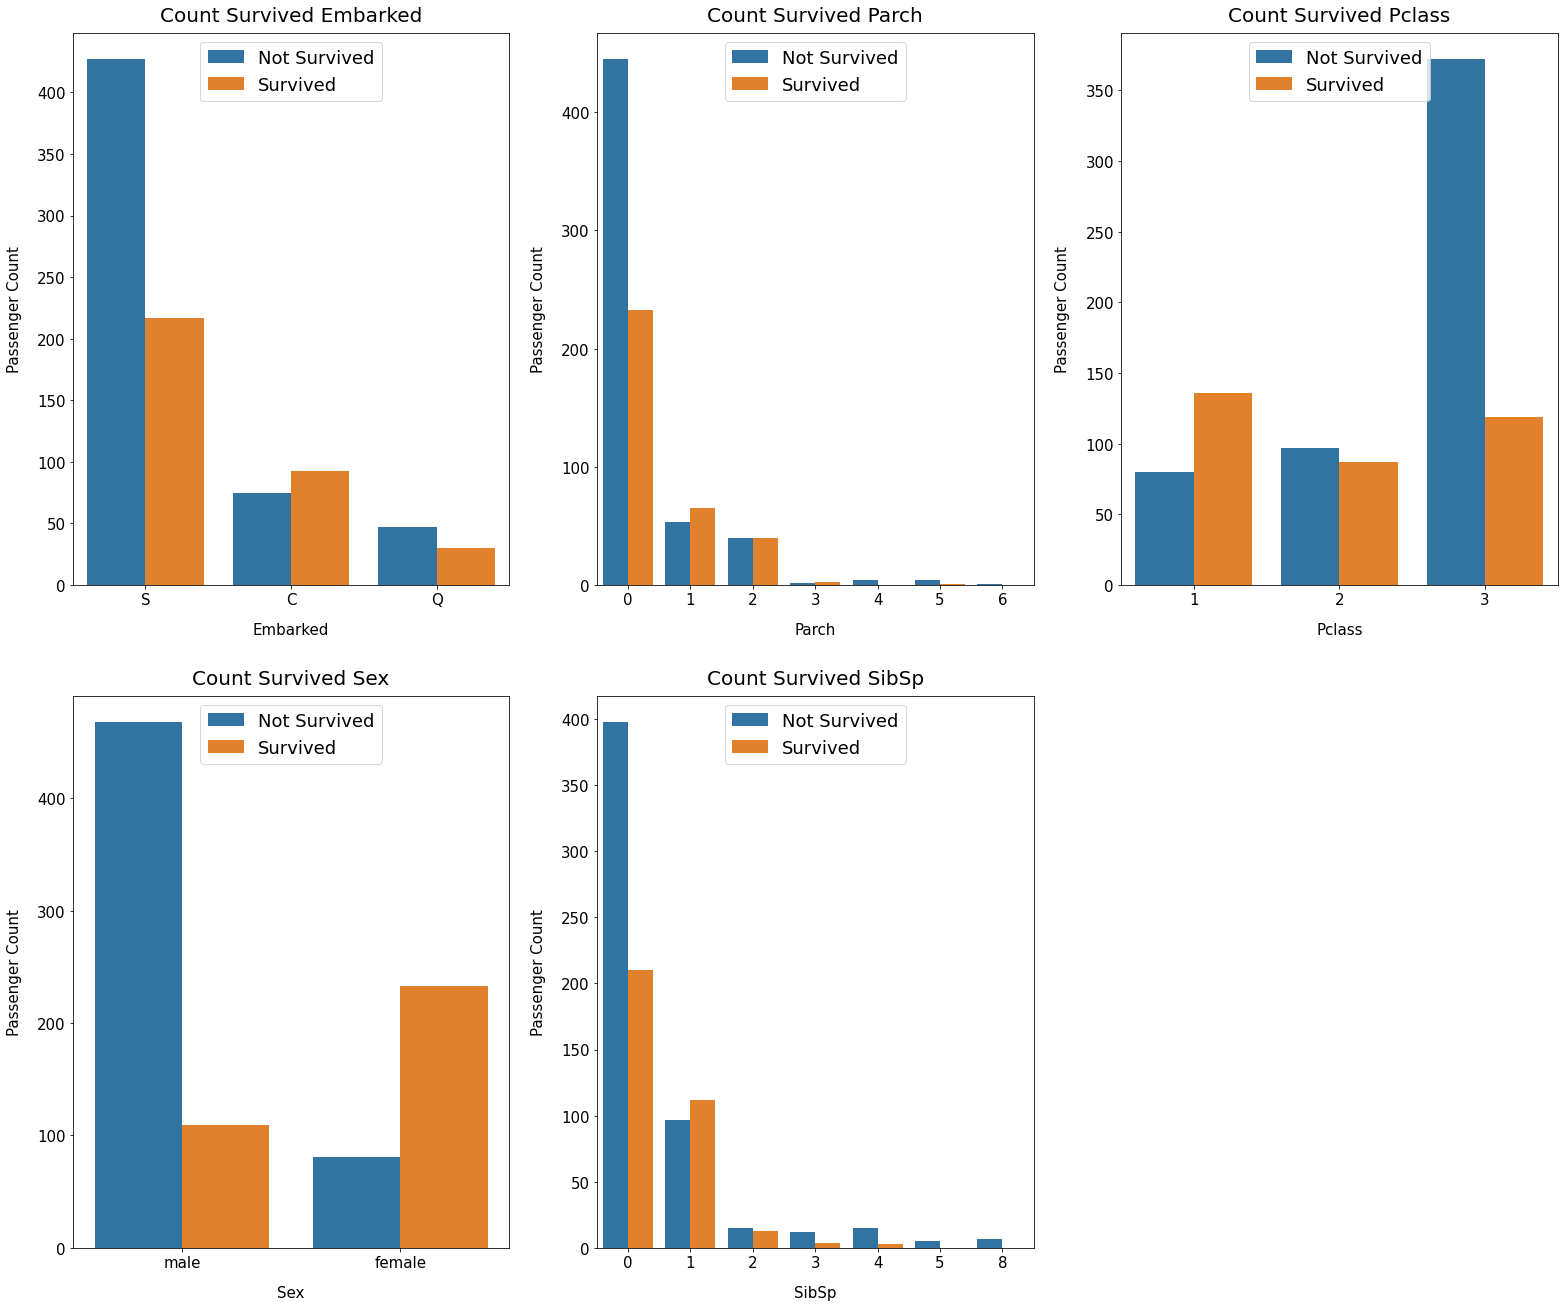

In [71]:
# análise variáveis categóricas

# > tendência à sobrevivência 
  # embarcados em Cherbourg
  # tamanhos de família entre 2 a 4 integrantes
  # classe Alta
  # sexo feminino

# < tendência à sobrevivência 
  # embarcados em Southampton
  # tamanhos de família: viajante solitário ou > 4
  # classe baixa
  # sexo masculino  

category_vars = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 15))
plt.subplots_adjust(right=1.5, top=1.25)

for i, field in enumerate(category_vars, 1):    
    plt.subplot(2, 3, i)
    sns.countplot(x=field, hue='Survived', data=df_all)
    
    plt.xlabel('{}'.format(field), size=15, labelpad=15)
    plt.ylabel('Passenger Count', size=15, labelpad=15)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title('Count Survived {}'.format(field), size=20, y=1.01)

plt.show()

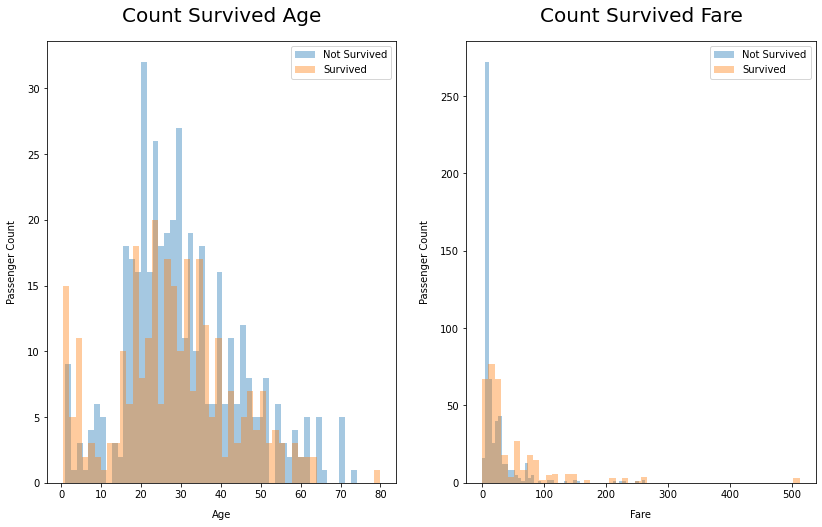

In [72]:
# análise variáveis contínuas

# > tendência à sobrevivência 
  # menores de 15 anos
  # taxas mais caras de entrada

# < tendência à sobrevivência 
  # alta taxa de mortalidade entre 20 e 30 anos 
  # taxas mais baratas de entrada

num_vars = ['Age', 'Fare']

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 12))
plt.subplots_adjust(right=1.5, top=1.25)

for i, field in enumerate(num_vars, 1):    
    plt.subplot(2, 3, i)
    
    df_filter = df_all.loc[df_all['Survived']==0]
    sns.distplot(df_filter[field],bins=50,kde=False,hist=True)

    df_filter = df_all.loc[df_all['Survived']==1]
    sns.distplot(df_filter[field],bins=50,kde=False,hist=True)
    
    plt.xlabel('{}'.format(field), size=10, labelpad=10)
    plt.ylabel('Passenger Count', size=10, labelpad=10)    
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=10)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 10})
    plt.title('Count Survived {}'.format(field), size=20, y=1.03)

plt.show()

**Conclusões:**

- A classe parece influenciar na chance de a pessoa sobreviver, já que passageiros da 3a classe tiveram a menor taxa de sobreviêcia enquanto que passageiros da 1a classe tiveram a maior;
- O sexo também parece influenciar, já que mais de 70% das mulheres sobreviveu, enquanto que menos de 20% dos homens sobreviveram;
- Idade parece influenciar, já que a taxa de sobrevivência parece ser maior para crianças;
- O local de embarque parece ter relação com o fato de a pessoa sobreviver ou não. Seria o local de embarque uma proxy para a posição em que as pessoas ficaram no barco e isso, de certa forma, influenciou no fato de os passageiros sobreviverem ou não?
- Ter cabine também parece impactar consideravelmente as chances de a pessoa sobreviver;
- Pessoas que pagaram mais pela passagem apresentaram maior taxa de sobrevivência (possível correlação com ter ou não cabine);
- Outro fator de destaque é o tamanho da família, que já acompanhados, mulheres casadas e com criança aparentam ter maior taxa de sobrevivência.

# 5. Feature Engineering

Agora que temos os dados limpos e entendemos um pouco mais do problema de negócio, hora de tentar criar variáveis, a partir das existentes, para aumentar a explicabilidade do modelo. Vale consultar a aba de **Notebooks** da competição, observar ideias que as pessoas tiveram e aplicar elas aqui. Como falamos em aula, não tem uma receita para feature engineering, a experiência conta bastante então é um bom momento para pegarmos umas ideias diferentes.

Deixo algumas ideias aqui: será que o fato de o número da cabine ser nulo têm alguma influência sobre a probabilidade de a pessoa sobreviver ou não? Na variável com o nome do passageiro, temos o título (Mr., Mrs., etc). Será que o título, de alguma forma, contribui para a probabilidade de sobrevivência?

Usem a criatividade e, principalmente, testem várias coisas diferentes!!

In [73]:
df_all_plusTest.groupby(['Sex', 'Pclass'])['Age'].median()

Sex     Pclass
female  1         36.0
        2         28.0
        3         22.0
male    1         42.0
        2         29.5
        3         25.0
Name: Age, dtype: float64

In [74]:
df_all_plusTest['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [75]:
# Preencher Fare, Age e Embarked - poucos dados 

# Median Fare para condition([3][0][0] - 3=Pclass,0=Parch,SibSp - classe baixa, sem acompanhantes e dependentes) 
med_fare = df_all_plusTest.groupby(['Pclass', 'Parch', 'SibSp'])['Fare'].median()[3][0][0]
df_all_plusTest['Fare'] = df_all_plusTest['Fare'].fillna(med_fare)

# Preenchendo missing values Embarked com 'S' - o de > frequencia
df_all_plusTest['Embarked'] = df_all_plusTest['Embarked'].fillna('S')

# Preenchendo missing values Age com medians de Sex e Pclass
df_all_plusTest['Age'] = df_all_plusTest.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

In [76]:
# criar Title e IsMarried
df_all_plusTest['Title'] = df_all_plusTest['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

df_all_plusTest['Is_Married'] = 0
df_all_plusTest['Is_Married'].loc[df_all_plusTest['Title'] == 'Mrs'] = 1 # índice alto de sobrevivência
df_all_plusTest['Is_Married'].loc[df_all_plusTest['Title'] == 'Mr'] = 1 # índice alto de sobrevivência

In [77]:
df_all_plusTest['Embarked'].loc[df_all_plusTest['Embarked'] == 'S'] = 0 
df_all_plusTest['Embarked'].loc[df_all_plusTest['Embarked'] == 'C'] = 1 
df_all_plusTest['Embarked'].loc[df_all_plusTest['Embarked'] == 'Q'] = 2 

In [78]:
# os títulos predominantes são Mr, Miss, Mrs. Os demais, vamos agrupar em uma nova categoria, outro
titulos_predominantes = ['Mr', 'Miss', 'Mrs']

df_all_plusTest['Title'] = df_all_plusTest['Title'].apply(lambda x: x if x in titulos_predominantes else 'Outro')

In [79]:
# convertendo title pra categórica
df_all_plusTest['Title'].loc[df_all_plusTest['Title'] == 'Mr'] = 0 
df_all_plusTest['Title'].loc[df_all_plusTest['Title'] == 'Mrs'] = 1 
df_all_plusTest['Title'].loc[df_all_plusTest['Title'] == 'Miss'] = 2 
df_all_plusTest['Title'].loc[df_all_plusTest['Title'] == 'Outro'] = 3 

In [80]:
# criando Family Size = Parch + SibSp
df_all_plusTest['Family_Size'] = df_all_plusTest['SibSp'] + df_all_plusTest['Parch'] + 1

# criando Family_Size_Grouped - 0: alone, small, medium
family_map = {1: 0, 2: 1, 3: 1, 4: 1, 5: 2, 6: 2, 7: 3, 8: 3, 11: 3}
df_all_plusTest['Family_Size_Grouped'] = df_all_plusTest['Family_Size'].map(family_map)

In [81]:
# convertendo sex pra categórica
df_all_plusTest['Sex'].loc[df_all_plusTest['Sex'] == 'male'] = 0 
df_all_plusTest['Sex'].loc[df_all_plusTest['Sex'] == 'female'] = 1 

In [82]:
# indicando se há ou não cabine
df_all_plusTest['Has_Cabin'] = 0
# Cria variável has_cabin que recebe 1 se o valor de Cabin não é nulo
# e 0 se é nulo
df_all_plusTest['Has_Cabin'] = np.where(df_all_plusTest['Cabin'].isnull(), 0, 1)
# Dropa variável Cabin
df_all_plusTest.drop('Cabin', axis=1, inplace=True)

In [83]:
# agrupando ticket
df_all_plusTest['Ticket_Frequency'] = df_all_plusTest.groupby('Ticket')['Ticket'].transform('count')
# dropando ticket - variável sem correlação
df_all_plusTest.drop('Ticket', axis=1, inplace=True)

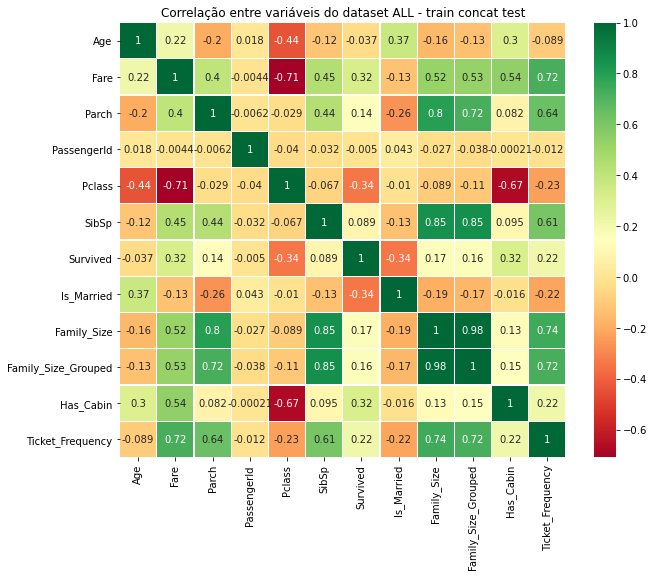

In [84]:
# variáveis ficaram mais correlatas - Family Size: Fare, Parch e SibSp / Is_Married e Age / Fare e Survived / 
# SibSp: Fare e Parch / Has_Cabin: Fare e Survived
sns.heatmap(df_all_plusTest.corr(method = 'spearman'),annot=True,cmap='RdYlGn',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.title('Correlação entre variáveis do dataset ALL - train concat test')
plt.show()

In [85]:
df_all_plusTest.drop('Name', axis=1, inplace=True)

In [86]:
# Dividindo - separando df_train e df_test
df_raw_train = df_all_plusTest.loc[:890]
df_final_test = df_all_plusTest.loc[891:]
dfs = [df_train, df_final_test]
# Fazendo separação em treino e teste, deixando 80% dos dados para treino e 20% para teste
df_train, df_test = train_test_split(df_raw_train, stratify=df_raw_train['Survived'] , test_size=0.2, random_state=42)

In [87]:
df_train.shape, df_test.shape, df_raw_train.shape, df_final_test.shape, df_all_plusTest.shape

((712, 15), (179, 15), (891, 15), (418, 15), (1309, 15))

In [88]:
# verificar se tem NULL no df_raw_train, assim não haverá no df_train e df_test 
100*(df_raw_train.isnull().sum()/df_raw_train.shape[0])

Age                    0.0
Embarked               0.0
Fare                   0.0
Parch                  0.0
PassengerId            0.0
Pclass                 0.0
Sex                    0.0
SibSp                  0.0
Survived               0.0
Title                  0.0
Is_Married             0.0
Family_Size            0.0
Family_Size_Grouped    0.0
Has_Cabin              0.0
Ticket_Frequency       0.0
dtype: float64

# 6. Feature Selection

De todas as Features que temos, vamos identificar quais, de fato, são relevates para o nosso problema. Faremos isso em duas etapas, como vimos em aula.

### 6.1 Filter Method

Nesta etapa verificamos se as relações observadas entre as variáveis e o target são estatisticamente significativas. Para isso, utilizamos testes de hipótese como ANOVA e chi2. Analisando os p-valores, identificamos variáveis que não são estatisticamente significativas e as removemos do conjunto.

### 6.2 Wrapper Method

Aqui utilizamos alguns algoritmos como Boruta ou RFE, cuja ideia é identificar quais as variáveis que, de fato contribuem para o modelo. Tais algoritmos fazem isso, por exemplo, testando a feature contra uma versão randomizada de si mesma ou avaliando se um modelo com a feature performa signficativamente melhor do que o mesmo modelo sem a feature em questão.

### Filter Method

In [89]:
df_raw_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  891 non-null    float64
 1   Embarked             891 non-null    object 
 2   Fare                 891 non-null    float64
 3   Parch                891 non-null    int64  
 4   PassengerId          891 non-null    int64  
 5   Pclass               891 non-null    int64  
 6   Sex                  891 non-null    object 
 7   SibSp                891 non-null    int64  
 8   Survived             891 non-null    float64
 9   Title                891 non-null    object 
 10  Is_Married           891 non-null    int64  
 11  Family_Size          891 non-null    int64  
 12  Family_Size_Grouped  891 non-null    int64  
 13  Has_Cabin            891 non-null    int32  
 14  Ticket_Frequency     891 non-null    int64  
dtypes: float64(3), int32(1), int64(8), objec

In [90]:
df_train.sample(2)

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title,Is_Married,Family_Size,Family_Size_Grouped,Has_Cabin,Ticket_Frequency
285,18.0,0,13.0,0,229,2,0,0,0.0,0,1,1,0,0,1
546,36.0,0,71.0,2,541,1,1,0,1.0,2,0,3,1,1,2


In [91]:
# validação ANOVA e CHI2

# divisão e escolha variáveis
X = df_raw_train.drop('Survived',axis=1)
Y = df_raw_train['Survived']

# separação variáveis
X_train_num = X.loc[:,['Age', 'Fare']] # usa o anova
X_train_cat = X.loc[:,['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Title', 'Is_Married', 'Family_Size', \
                       'Family_Size_Grouped', 'Has_Cabin', 'Ticket_Frequency']] # usa o chi2 

###### Variáveis Numéricas

In [92]:
# ANOVA análise
selected_anova = f_classif(X_train_num, Y)
selected_anova

(array([ 3.06699269, 63.03076423]), array([8.02419979e-02, 6.12018934e-15]))

In [93]:
p_values_num = pd.Series(selected_anova[1])
p_values_num.index = X_train_num.columns 
p_values_num = p_values_num[p_values_num<0.05]
p_values_num.index

Index(['Fare'], dtype='object')

##### Variáveis Categóricas

Para não precisar fazer o encoding das variáveis categóricas agora, vamos utilizar o teste de chi2 do scipy

In [94]:
# chi2 análise
selected_chi2 = chi2(X_train_cat, Y)
selected_chi2

(array([ 11.35311684,  10.09749911,  30.87369944, 170.34812709,
          2.58186538, 228.61467532,  29.05863095,   0.33678704,
          5.39776549,  68.99741156,   5.71556761]),
 array([7.53214554e-04, 1.48470676e-03, 2.75378563e-08, 6.21058490e-39,
        1.08094210e-01, 1.19526082e-51, 7.02205567e-08, 5.61689700e-01,
        2.01625497e-02, 9.85927553e-17, 1.68151273e-02]))

In [95]:
p_values_cat = pd.Series(selected_chi2[1])
p_values_cat.index = X_train_cat.columns 
p_values_cat = p_values_cat[p_values_cat<0.05]
p_values_cat.index

Index(['Embarked', 'Parch', 'Pclass', 'Sex', 'Title', 'Is_Married',
       'Family_Size_Grouped', 'Has_Cabin', 'Ticket_Frequency'],
      dtype='object')

> variáveis ['Fare'] e ['Embarked', 'Parch', 'Pclass', 'Sex', 'Title', 'Is_Married',
       'Family_Size_Grouped', 'Has_Cabin', 'Ticket_Frequency'] que influenciam na qualidade do resultado

### Wrapper Method

Para utilizar os Wrapper Methods precisamos fazer encoding das variáveis categóricas. Para isso, vamos utilizar o Frequency Encoder - transformar em object

In [96]:
# avaliando Boruta
forest = RandomForestRegressor(n_jobs = -1, max_depth = 5)

# fit boruta
boruta_selector = BorutaPy(forest, n_estimators = 50, max_iter=100, random_state = 0)
boruta_selector.fit(np.array(X_train_num), np.array(Y))

BorutaPy(estimator=RandomForestRegressor(max_depth=5, n_estimators=50,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x16A99093B40),
         n_estimators=50, random_state=RandomState(MT19937) at 0x16A99093B40)

In [97]:
# indica as colunas que ficam = "True"
boruta_selector.support_

array([ True,  True])

In [98]:
# indica as em dúvida = "True"
boruta_selector.support_weak_

array([False, False])

In [99]:
# columnas consideradas pelo boruto
X_train_num.loc[:, boruta_selector.support_].columns.tolist()

['Age', 'Fare']

In [100]:
boruta_selector.fit(np.array(X_train_cat), np.array(Y))

BorutaPy(estimator=RandomForestRegressor(max_depth=5, n_estimators=50,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x16A99093B40),
         n_estimators=50, random_state=RandomState(MT19937) at 0x16A99093B40)

In [101]:
# indica as colunas que ficam = "True"
boruta_selector.support_

array([False, False,  True,  True, False,  True, False,  True, False,
        True,  True])

In [102]:
# indica as em dúvida = "True"
boruta_selector.support_weak_

array([False, False, False, False, False, False, False, False,  True,
       False, False])

In [103]:
# columnas consideradas pelo boruto
X_train_cat.loc[:, boruta_selector.support_].columns.tolist()

['Pclass', 'Sex', 'Title', 'Family_Size', 'Has_Cabin', 'Ticket_Frequency']

> Boruta analysis - ['Age', 'Fare'] + ['Pclass', 'Sex', 'Title', 'Family_Size', 'Has_Cabin', 'Ticket_Frequency']

In [104]:
# RFE

forest = RandomForestRegressor(n_jobs = -1, max_depth = 5)

# 1a Selação (Random Forest) - neg_mean_squared_error: busca inverter a queda de performance, aumentou o MSE piora 
# então negativa pra melhorar 
rfecv_RFC = RFECV(estimator=forest, scoring='neg_mean_squared_error')
rfecv_RFC.fit(np.array(X_train_num), np.array(Y))

RFECV(estimator=RandomForestRegressor(max_depth=5, n_jobs=-1),
      scoring='neg_mean_squared_error')

In [105]:
print(rfecv_RFC.n_features_) # Número de features selecionadas como as mais importantes 
print(rfecv_RFC.support_) # Vetor de booleans. True se a variável deve ser mantida e False caso contrário
mask_RFC = rfecv_RFC.support_

2
[ True  True]


In [106]:
# colunas selecionadas pelo RFE
cols_drop_RFE= [ x for x in mask_RFC] # apenas invertendo o vetor de true/false
cols_drop_RFE= X_train_num.loc[:,cols_drop_RFE].columns.tolist()
cols_drop_RFE

['Age', 'Fare']

In [107]:
rfecv_RFC.fit(np.array(X_train_cat), np.array(Y))

RFECV(estimator=RandomForestRegressor(max_depth=5, n_jobs=-1),
      scoring='neg_mean_squared_error')

In [108]:
print(rfecv_RFC.n_features_) # Número de features selecionadas como as mais importantes 
print(rfecv_RFC.support_) # Vetor de booleans. True se a variável deve ser mantida e False caso contrário
mask_RFC = rfecv_RFC.support_
cols_drop_RFE= [ x for x in mask_RFC] # apenas invertendo o vetor de true/false
cols_drop_RFE= X_train_cat.loc[:,cols_drop_RFE].columns.tolist()
cols_drop_RFE

9
[ True False  True  True  True  True False  True  True  True  True]


['Embarked',
 'Pclass',
 'Sex',
 'SibSp',
 'Title',
 'Family_Size',
 'Family_Size_Grouped',
 'Has_Cabin',
 'Ticket_Frequency']

> variáveis ['Age', 'Fare'] e ['Embarked', 'Pclass', 'Sex', 'SibSp', 'Title', 'Family_Size', 'Family_Size_Grouped',  'Has_Cabin',  'Ticket_Frequency'] que influenciam na qualidade do resultado

# 7. Data Prep

Tendo em mãos as variáveis selecionadas, hora de pré processar esses dados para entrar no modelo. Hora de começar nosso Pipeline criando um Column Transformer para fazer encoding das variáveis categóricas e Scaling das variáveis numéricas. Qual encoder e qual Scaler usar fica por conta de vocês :)

In [109]:
df_train.shape, df_test.shape, df_raw_train.shape, df_final_test.shape, df_all_plusTest.shape

((712, 15), (179, 15), (891, 15), (418, 15), (1309, 15))

In [110]:
df_train.dtypes

Age                    float64
Embarked                object
Fare                   float64
Parch                    int64
PassengerId              int64
Pclass                   int64
Sex                     object
SibSp                    int64
Survived               float64
Title                   object
Is_Married               int64
Family_Size              int64
Family_Size_Grouped      int64
Has_Cabin                int32
Ticket_Frequency         int64
dtype: object

In [111]:
# carga dados
X_train = df_train.drop('Survived', axis=1)
y_train = df_train['Survived']

X_test = df_test.drop('Survived', axis=1)
y_test = df_test['Survived']

X_final_test = df_final_test.drop('Survived', axis=1)

In [112]:
# alteração objetos X_Train
X_train['Embarked'] = X_train['Embarked'].astype('object')
X_train['Parch'] = X_train['Parch'].astype('object')
X_train['Pclass'] = X_train['Pclass'].astype('object')
X_train['Sex'] = X_train['Sex'].astype('object')
X_train['SibSp'] = X_train['SibSp'].astype('object')
X_train['Title'] = X_train['Title'].astype('object')
X_train['Is_Married'] = X_train['Is_Married'].astype('object')
X_train['Family_Size'] = X_train['Family_Size'].astype('object')
X_train['Family_Size_Grouped'] = X_train['Family_Size_Grouped'].astype('object')
X_train['Has_Cabin'] = X_train['Has_Cabin'].astype('object')
X_train['Ticket_Frequency'] = X_train['Ticket_Frequency'].astype('object')

In [113]:
# alteração objetos X_test
X_test['Embarked'] = X_test['Embarked'].astype('object')
X_test['Parch'] = X_test['Parch'].astype('object')
X_test['Pclass'] = X_test['Pclass'].astype('object')
X_test['Sex'] = X_test['Sex'].astype('object')
X_test['SibSp'] = X_test['SibSp'].astype('object')
X_test['Title'] = X_test['Title'].astype('object')
X_test['Is_Married'] = X_test['Is_Married'].astype('object')
X_test['Family_Size'] = X_test['Family_Size'].astype('object')
X_test['Family_Size_Grouped'] = X_test['Family_Size_Grouped'].astype('object')
X_test['Has_Cabin'] = X_test['Has_Cabin'].astype('object')
X_test['Ticket_Frequency'] = X_test['Ticket_Frequency'].astype('object')

In [114]:
# alteração objetos X_final_test
X_final_test['Embarked'] = X_final_test['Embarked'].astype('object')
X_final_test['Parch'] = X_final_test['Parch'].astype('object')
X_final_test['Pclass'] = X_final_test['Pclass'].astype('object')
X_final_test['Sex'] = X_final_test['Sex'].astype('object')
X_final_test['SibSp'] = X_final_test['SibSp'].astype('object')
X_final_test['Title'] = X_final_test['Title'].astype('object')
X_final_test['Is_Married'] = X_final_test['Is_Married'].astype('object')
X_final_test['Family_Size'] = X_final_test['Family_Size'].astype('object')
X_final_test['Family_Size_Grouped'] = X_final_test['Family_Size_Grouped'].astype('object')
X_final_test['Has_Cabin'] = X_final_test['Has_Cabin'].astype('object')
X_final_test['Ticket_Frequency'] = X_final_test['Ticket_Frequency'].astype('object')

In [115]:
X_train['Parch'].unique()

array([1, 4, 0, 2, 5, 3, 6], dtype=object)

In [116]:
vars_encs = ['SibSp', 'Family_Size', 'Ticket_Frequency']

# Carregando os pipes
pipe_num_min_max = ('min_max_scaler', MinMaxScaler(), ['Age', 'Fare'])
pipe_cat_one_hot = ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'), \
                    ['Embarked', 'Pclass', 'Sex', 'Title', 'Is_Married', 'Has_Cabin'])
pipe_cat_ordinal = ('ordinal_encoder', OrdinalEncoder(categories=[[0, 1, 2, 3]]), ['Family_Size_Grouped'])
pipe_cat_target = ('target_encoder', TargetEncoder(), ['Parch'])
pipe_cat_frequency = ('frequency_encoder', CountFrequencyCategoricalEncoder(encoding_method="frequency", \
                                                                            variables=vars_encs), vars_encs) 

In [117]:
# monta o fluxo de transformações
transformers = [pipe_num_min_max,
                pipe_cat_one_hot,
                pipe_cat_ordinal,
                pipe_cat_target,
                pipe_cat_frequency]
pre_processador = ColumnTransformer(transformers)

# 8. Ajuste do modelo

<!-- Features selecionadas, Data Prep estruturado, hora de finalizar a construção do Pipeline com o modelo escolhido. Como trata-se de um problema de **classificação**, em que a variável target é **categórica**, qual modelo utilizamos mesmo? Por enquanto só vimos dois modelos, um para regressão e outro para classificação, mas se quiserem se aventurar em outros modelos, fiquem a vontade para procurar e testar! -->

Uma vez construído o Pipeline, hora de fazer o fit utilizando **validação cruzada**.

## 8.1 Regressão Logística

In [118]:
# modelo
model_reglog = Pipeline(steps=[('pre_processor', pre_processador), 
                        ('reg_log', LogisticRegression(random_state=123))])

In [119]:
# ajusta / treina modelo
model_reglog.fit(X_train, y_train)

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['Age', 'Fare']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Embarked', 'Pclass', 'Sex',
                                                   'Title', 'Is_Married',
                                                   'Has_Cabin']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(categories=[[0,
                                                                              1,
                                                                              2,
                                                                         

In [120]:
# Calcula predição do modelo para checar fitting treino e teste
yhat = model_reglog.predict(X_test)

In [121]:
# Acurácia - quantos % dos passegeiros o modelo classificou corretamente

# % acerto treino
perc_logreg_train = round(model_reglog.score(X_train, y_train) * 100, 2)
print("% estimado Acurácia regressão logística no DataSet de treino {:.2f}".format(perc_logreg_train))

perc_logreg_test = round(accuracy_score(y_test, yhat) * 100, 2)
print("% estimado Acurácia regressão logística no DataSet de teste {:.2f}".format(perc_logreg_test))

% estimado Acurácia regressão logística no DataSet de treino 83.15
% estimado Acurácia regressão logística no DataSet de teste 82.12


> o modelo aparenta estar bem ajustado para regressão logística, testando kfold estratificado

In [122]:
# kfold estratificado
cv_kfold_stratified = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

In [123]:
# garante a proporção das classes - pode como ideal já deixar o estratificado
cv_kfold_stratified_results = cross_validate(estimator=model_reglog,
                                               X=X_train,
                                               y=y_train,
                                               scoring='neg_log_loss',
                                               cv=cv_kfold_stratified,
                                               return_train_score=True,
                                               n_jobs=-1)

In [124]:
train_scores_cv_kfold_stratified_default = cv_kfold_stratified_results['train_score']
test_scores_cv_kfold_stratified_default = cv_kfold_stratified_results['test_score']
print(f'Log Loss Modelo Log Reg - KFold Stratified Treino: {np.mean(train_scores_cv_kfold_stratified_default)}')
print(f'Log Loss Modelo Log Reg - KFold Stratified Teste: {np.mean(test_scores_cv_kfold_stratified_default)}')

Log Loss Modelo Log Reg - KFold Stratified Treino: -0.41355536175330776
Log Loss Modelo Log Reg - KFold Stratified Teste: -0.4327568928687122


> o modelo aparenta estar bem ajustado para regressão logística

In [125]:
scores = cross_val_score(model_reglog, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.90277778 0.77777778 0.8028169  0.81690141 0.83098592 0.8028169
 0.83098592 0.78873239 0.85915493 0.88732394]
Mean: 0.8300273865414709
Standard Deviation: 0.039388039427745984


> o modelo reg log com 83% de acuracy e desvio padrão de 3,9%

## 8.2 KNN

In [126]:
model_knn = Pipeline(steps=[('pre_processor', pre_processador),
                            ('model', KNeighborsClassifier())])

In [127]:
# ajusta / treina modelo
model_knn.fit(X_train, y_train)

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['Age', 'Fare']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Embarked', 'Pclass', 'Sex',
                                                   'Title', 'Is_Married',
                                                   'Has_Cabin']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(categories=[[0,
                                                                              1,
                                                                              2,
                                                                         

In [128]:
# Calcula predição do modelo para checar fitting treino e teste
yhat = model_knn.predict(X_test)

In [129]:
# Acurácia - quantos % dos passegeiros o modelo classificou corretamente, comparando modelo sem ajuste

# % acerto treino
perc_knn_train = round(model_knn.score(X_train, y_train) * 100, 2)
print("% estimado Acurácia K-N Neighbors no DataSet de treino {:.2f}".format(perc_knn_train))

perc_knn_test = round(accuracy_score(y_test, yhat) * 100, 2)
print("% estimado Acurácia K-N Neighbors no DataSet de teste {:.2f}".format(perc_knn_test))

% estimado Acurácia K-N Neighbors no DataSet de treino 85.96
% estimado Acurácia K-N Neighbors no DataSet de teste 78.21


In [130]:
# kfold teste
cv_kfold = KFold(n_splits=10, shuffle=True, random_state=123)

# validação cruzada testa a performance do modelo pra base
cv_kfold_results = cross_validate(estimator=model_knn,
                                   X=X_train,
                                   y=y_train,
                                   scoring='neg_log_loss', # métrica de erro que se pretende estimar
                                   cv=cv_kfold,
                                   return_train_score=True,
                                   n_jobs=-1) # todos os jobs simultâneos

In [131]:
# o treino deve ser > q test, o problema é q a diferença está muito alta
train_scores_cv_kfold_default = cv_kfold_results['train_score']
test_scores_cv_kfold_default = cv_kfold_results['test_score']
print(f'Log Loss Modelo KNN - KFold Treino: {np.mean(train_scores_cv_kfold_default)}')
print(f'Log Loss Modelo KNN - KFold Teste: {np.mean(test_scores_cv_kfold_default)}')

Log Loss Modelo KNN - KFold Treino: -0.29288741440403887
Log Loss Modelo KNN - KFold Teste: -1.9932165628854939


> o modelo aparenta overfitting, mas pode melhorar através do GridSearchCV, ajustado abaixo com GridSearchCV

In [132]:
scores = cross_val_score(model_knn, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.88888889 0.75       0.74647887 0.8028169  0.83098592 0.76056338
 0.83098592 0.8028169  0.81690141 0.87323944]
Mean: 0.8103677621283255
Standard Deviation: 0.04618645267379523


> o modelo reg log com 81,0% de acuracy e desvio padrão de 4,6%

## 8.3 SVM

In [133]:
model_svm = Pipeline(steps=[('pre_processor', pre_processador),
                            ('model', SVC(kernel='rbf', probability=True, random_state=123))])

In [134]:
# ajusta / treina modelo
model_svm.fit(X_train, y_train)

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['Age', 'Fare']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Embarked', 'Pclass', 'Sex',
                                                   'Title', 'Is_Married',
                                                   'Has_Cabin']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(categories=[[0,
                                                                              1,
                                                                              2,
                                                                         

In [135]:
# Calcula predição do modelo para checar fitting treino e teste
yhat = model_svm.predict(X_test)

In [136]:
# Acurácia - quantos % dos passegeiros o modelo classificou corretamente

# % acerto treino
perc_svm_train = round(model_svm.score(X_train, y_train) * 100, 2)
print("% estimado Acurácia Support Vector Machine no DataSet de treino {:.2f}".format(perc_svm_train))

perc_svm_test = round(accuracy_score(y_test, yhat) * 100, 2)
print("% estimado Acurácia Support Vector Machine no DataSet de teste {:.2f}".format(perc_svm_test))

% estimado Acurácia Support Vector Machine no DataSet de treino 84.13
% estimado Acurácia Support Vector Machine no DataSet de teste 82.68


In [137]:
# cada interação será deixado alguém de fora para fazer a validação 
# correção para o log loss
def loss_scorer(y_true, y_pred, eps=1e-15, normalize=True, sample_weight=None, labels=None):
    return -log_loss(y_true, y_pred, eps, normalize, sample_weight, labels=__LABELS__)
global __LABELS__
__LABELS__ = list(set(y_train))
scorer_loss = make_scorer(loss_scorer, greater_is_better=True, needs_proba=True)

# leave one out
cv_leave_one_out = LeaveOneOut()

In [138]:
cv_loo_default_results = cross_validate(estimator=model_svm,
                                               X=X_train,
                                               y=y_train,
                                               scoring=scorer_loss, # score criado no item acima para o corretivo
                                               cv=cv_leave_one_out,
                                               return_train_score=True,
                                               n_jobs=-1)

In [139]:
train_scores_cv_loo_default = cv_loo_default_results['train_score']
test_scores_cv_default = cv_loo_default_results['test_score']
print(f'Log Loss Modelo SVM - LOOCV Treino: {np.mean(train_scores_cv_loo_default)}')
print(f'Log Loss Modelo SVM - LOOCV Teste: {np.mean(test_scores_cv_default)}')

Log Loss Modelo SVM - LOOCV Treino: -0.4006156635988736
Log Loss Modelo SVM - LOOCV Teste: -0.44622304669818047


> o modelo aparenta estar bem ajustado para Support Vector Machine

In [140]:
scores = cross_val_score(model_svm, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.90277778 0.76388889 0.78873239 0.84507042 0.84507042 0.77464789
 0.8028169  0.8028169  0.81690141 0.90140845]
Mean: 0.8244131455399062
Standard Deviation: 0.04617882964832798


> o modelo reg log com 82,5% de acuracy e desvio padrão de 4,6%

## 8.4 Naive Bayes

In [141]:
model_gnb = Pipeline(steps=[('pre_processor', pre_processador),
                            ('model', GaussianNB())])

In [142]:
# ajusta / treina modelo
model_gnb.fit(X_train, y_train)

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['Age', 'Fare']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Embarked', 'Pclass', 'Sex',
                                                   'Title', 'Is_Married',
                                                   'Has_Cabin']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(categories=[[0,
                                                                              1,
                                                                              2,
                                                                         

In [143]:
# Calcula predição do modelo para checar fitting treino e teste
yhat = model_gnb.predict(X_test)

In [144]:
# Acurácia - quantos % dos passegeiros o modelo classificou corretamente

# % acerto treino
perc_gnb_train = round(model_gnb.score(X_train, y_train) * 100, 2)
print("% estimado Acurácia Gaussian Naive Bayes no DataSet de treino {:.2f}".format(perc_gnb_train))

perc_gnb_test = round(accuracy_score(y_test, yhat) * 100, 2)
print("% estimado Acurácia Gaussian Naive Bayes no DataSet de teste {:.2f}".format(perc_gnb_test))

% estimado Acurácia Gaussian Naive Bayes no DataSet de treino 77.67
% estimado Acurácia Gaussian Naive Bayes no DataSet de teste 73.74


> modelo de díficil ajuste, porém aparenta não overfitting e nem underfitting

In [145]:
# kfold teste
cv_kfold = KFold(n_splits=10, shuffle=True, random_state=123)

# validação cruzada testa a performance do modelo pra base
cv_kfold_results = cross_validate(estimator=model_gnb,
                                   X=X_train,
                                   y=y_train,
                                   scoring='neg_log_loss', # métrica de erro que se pretende estimar
                                   cv=cv_kfold,
                                   return_train_score=True,
                                   n_jobs=-1) # todos os jobs simultâneos

In [146]:
# o treino deve ser > q test, o problema é q a diferença está muito alta
train_scores_cv_kfold_default = cv_kfold_results['train_score']
test_scores_cv_kfold_default = cv_kfold_results['test_score']
print(f'Log Loss Modelo GNB - KFold Treino: {np.mean(train_scores_cv_kfold_default)}')
print(f'Log Loss Modelo GNB - KFold Teste: {np.mean(test_scores_cv_kfold_default)}')

Log Loss Modelo GNB - KFold Treino: -1.8384460931300033
Log Loss Modelo GNB - KFold Teste: -1.9537453347404206


> Alto índice de erro indicado pelo log loss

In [147]:
scores = cross_val_score(model_gnb, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.83333333 0.76388889 0.70422535 0.76056338 0.74647887 0.77464789
 0.76056338 0.74647887 0.8028169  0.8028169 ]
Mean: 0.7695813771517998
Standard Deviation: 0.03439926732970277


> baixa média de acurária 76,9% e desvio de 3,4%

## 8.5 Decision Tree

In [148]:
model_dt = Pipeline(steps=[('pre_processor', pre_processador),
                            ('model', DecisionTreeClassifier( random_state=123))])

In [149]:
# ajusta / treina modelo
model_dt.fit(X_train, y_train)

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['Age', 'Fare']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Embarked', 'Pclass', 'Sex',
                                                   'Title', 'Is_Married',
                                                   'Has_Cabin']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(categories=[[0,
                                                                              1,
                                                                              2,
                                                                         

In [150]:
# Calcula predição do modelo para checar fitting treino e teste
yhat = model_dt.predict(X_test)

In [151]:
# Acurácia - quantos % dos passegeiros o modelo classificou corretamente

# % acerto treino
perc_dt_train = round(model_dt.score(X_train, y_train) * 100, 2)
print("% estimado Acurácia Decision Tree no DataSet de treino {:.2f}".format(perc_dt_train))

perc_dt_test = round(accuracy_score(y_test, yhat) * 100, 2)
print("% estimado Acurácia Decision Tree no DataSet de teste {:.2f}".format(perc_dt_test))

% estimado Acurácia Decision Tree no DataSet de treino 99.16
% estimado Acurácia Decision Tree no DataSet de teste 81.01


> modelo com overfitting

In [152]:
# garante a proporção das classes - pode como ideal já deixar o estratificado
cv_kfold_stratified_results = cross_validate(estimator=model_dt,
                                               X=X_train,
                                               y=y_train,
                                               scoring='neg_log_loss',
                                               cv=cv_kfold_stratified,
                                               return_train_score=True,
                                               n_jobs=-1)

In [153]:
train_scores_cv_kfold_stratified_default = cv_kfold_stratified_results['train_score']
test_scores_cv_kfold_stratified_default = cv_kfold_stratified_results['test_score']
print(f'Log Loss Modelo Decision Tree - KFold Stratified Treino: {np.mean(train_scores_cv_kfold_stratified_default)}')
print(f'Log Loss Modelo Decision Tree - KFold Stratified Teste: {np.mean(test_scores_cv_kfold_stratified_default)}')

Log Loss Modelo Decision Tree - KFold Stratified Treino: -0.015612788519189675
Log Loss Modelo Decision Tree - KFold Stratified Teste: -7.33407553547061


> overfitting e alto índice de erro no teste

In [154]:
scores = cross_val_score(model_dt, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.84722222 0.69444444 0.73239437 0.87323944 0.78873239 0.71830986
 0.76056338 0.81690141 0.84507042 0.77464789]
Mean: 0.7851525821596244
Standard Deviation: 0.05693611107926725


## 8.6 Random Forest

In [155]:
model_rf = Pipeline(steps=[('pre_processor', pre_processador),
                           ('model', RandomForestClassifier(random_state=123))])

In [156]:
# ajusta / treina modelo
model_rf.fit(X_train, y_train)

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['Age', 'Fare']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Embarked', 'Pclass', 'Sex',
                                                   'Title', 'Is_Married',
                                                   'Has_Cabin']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(categories=[[0,
                                                                              1,
                                                                              2,
                                                                         

In [157]:
# Calcula predição do modelo para checar fitting treino e teste
yhat = model_rf.predict(X_test)

In [158]:
# Acurácia - quantos % dos passegeiros o modelo classificou corretamente

# % acerto treino
perc_rf_train = round(model_rf.score(X_train, y_train) * 100, 2)
print("% estimado Acurácia random forest no DataSet de treino {:.2f}".format(perc_rf_train))

perc_rf_test = round(accuracy_score(y_test, yhat) * 100, 2)
print("% estimado Acurácia random forest no DataSet de teste {:.2f}".format(perc_rf_test))

% estimado Acurácia random forest no DataSet de treino 99.16
% estimado Acurácia random forest no DataSet de teste 79.89


> modelo com overfitting

In [159]:
cv_loo_default_results = cross_validate(estimator=model_rf,
                                               X=X_train,
                                               y=y_train,
                                               scoring=scorer_loss, # score criado no item acima para o corretivo
                                               cv=cv_leave_one_out,
                                               return_train_score=True,
                                               n_jobs=-1)

In [160]:
train_scores_cv_loo_default = cv_loo_default_results['train_score']
test_scores_cv_default = cv_loo_default_results['test_score']
print(f'Log Loss Modelo Random Forest - LOOCV Treino: {np.mean(train_scores_cv_loo_default)}')
print(f'Log Loss Modelo Random Forest - LOOCV Teste: {np.mean(test_scores_cv_default)}')

Log Loss Modelo Random Forest - LOOCV Treino: -0.10999146718908116
Log Loss Modelo Random Forest - LOOCV Teste: -0.7983020264359056


> apesar do overfitting baixo índice de erro no treino e teste no leave out 

In [161]:
scores = cross_val_score(model_rf, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.91666667 0.76388889 0.74647887 0.8028169  0.83098592 0.77464789
 0.81690141 0.78873239 0.85915493 0.87323944]
Mean: 0.817351330203443
Standard Deviation: 0.05065143304178809


> Modelo Random Forest tem accuracy média de 81% com standard deviation of 5%.

### **Pergunta**: Como você compararia esses modelos? Qual métrica escolheria para a comparação? Por quê?

In [162]:
# log loss - métrica de erro, quanto menor melhor, comparação modelo sem otimização

classifiers = [model_reglog, model_svm, model_gnb, model_knn, model_dt, model_rf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    print(classifier[1])
    print(f'log_loss treino: {log_loss(y_train, classifier.predict_proba(X_train)[:,1])}')
    print(f'log_loss teste: {log_loss(y_test, classifier.predict_proba(X_test)[:,1])}')
    print(53*'-')

LogisticRegression(random_state=123)
log_loss treino: 0.4142148482102328
log_loss teste: 0.42796290102937945
-----------------------------------------------------
SVC(probability=True, random_state=123)
log_loss treino: 0.3996266082233013
log_loss teste: 0.44299833822624657
-----------------------------------------------------
GaussianNB()
log_loss treino: 1.8396885687489932
log_loss teste: 1.7173243119167017
-----------------------------------------------------
KNeighborsClassifier()
log_loss treino: 0.29119057197901527
log_loss teste: 2.0332923870390833
-----------------------------------------------------
DecisionTreeClassifier(random_state=123)
log_loss treino: 0.016729328235997067
log_loss teste: 6.389028020808672
-----------------------------------------------------
RandomForestClassifier(random_state=123)
log_loss treino: 0.10963328846346243
log_loss teste: 0.8486608202387388
-----------------------------------------------------


> log loss utilizada, capacidade de ajuste no Random Forest, no KNN e no SVM, afim de comparar com regressão logística
 (este ajustado). 
  GausianNB e Decision Tree praticamente descartados devido ao alto índice de erro.

# 9. Ajuste de hiperparâmetros

Vamos encontrar os melhores hiperparâmetros para os modelos acima no problema do Titanic. Fica a critério de vocês escolher qual técnica de otimização usar, mas é importante aplicá-las utilizando a **validação cruzada**.

Importante notar que o modelo Naive Bayes não tem hiperparâmetro e, portanto, não precisa ser otimizado.

## 9.1 KNN Model adjustments

> K-N Neigbors aparenta underfitting com alto índice de erro, porém, pode ser melhorado

In [163]:
k_range = list(range(1, 51))
weight_options = ['uniform', 'distance']

pipe_param_grid = dict(model__n_neighbors=k_range, model__weights=weight_options)

# stratified kfold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

grid_knn = GridSearchCV(model_knn, pipe_param_grid, cv=skf, scoring='accuracy', n_jobs=-1)
grid_knn.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
             estimator=Pipeline(steps=[('pre_processor',
                                        ColumnTransformer(transformers=[('min_max_scaler',
                                                                         MinMaxScaler(),
                                                                         ['Age',
                                                                          'Fare']),
                                                                        ('one_hot_encoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Embarked',
                                                                          'Pclass',
                                                                          'Sex',
                                                                

In [164]:
print(grid_knn.best_estimator_)
print(grid_knn.best_score_)
print(grid_knn.best_params_)

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['Age', 'Fare']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Embarked', 'Pclass', 'Sex',
                                                   'Title', 'Is_Married',
                                                   'Has_Cabin']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(categories=[[0,
                                                                              1,
                                                                              2,
                                                                         

In [165]:
knn_best = grid_knn.best_estimator_ # melhor performance de hiperparâmetros
knn_best.fit(X_train, y_train)

perc_knn_train = round(accuracy_score(y_train, knn_best.predict(X_train)) * 100, 2)
print("% estimado Acurácia K-N Neighbors no DataSet de treino com melhores parâmetros {:.2f}".format(perc_knn_train))

perc_knn_test = round(accuracy_score(y_test, knn_best.predict(X_test)) * 100, 2)
print("% estimado Acurácia K-N Neighbors no DataSet de teste com melhores parâmetros {:.2f}".format(perc_knn_test))

% estimado Acurácia K-N Neighbors no DataSet de treino com melhores parâmetros 83.71
% estimado Acurácia K-N Neighbors no DataSet de teste com melhores parâmetros 80.45


> aproximou o resultado de teste do treino

## 9.2 Random Forest Adjustments

In [166]:
# definição hiperparâmetros para Random Forest
criterion = ["gini", "entropy"]
min_samples_leaf = [1, 5, 10,]
min_samples_split = [2, 4, 10,]
n_estimators = [100,500,11000,1500]
param_grid = dict(model__criterion = criterion, \
                  model__min_samples_leaf = min_samples_leaf, \
                  model__min_samples_split = min_samples_split, \
                  model__n_estimators = n_estimators)

grid_rf = RandomizedSearchCV(model_rf, param_grid,  n_iter=10, cv=skf, scoring='accuracy', \
                             verbose=1, random_state=123, n_jobs=-1)
grid_rf.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.4min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('pre_processor',
                                              ColumnTransformer(transformers=[('min_max_scaler',
                                                                               MinMaxScaler(),
                                                                               ['Age',
                                                                                'Fare']),
                                                                              ('one_hot_encoder',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['Embarked',
                                                                                'Pclass',
                                                                                'Sex'

In [167]:
# print melhores parâmetros
print(grid_rf.best_estimator_)
print(grid_rf.best_score_)
print(grid_rf.best_params_)

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['Age', 'Fare']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Embarked', 'Pclass', 'Sex',
                                                   'Title', 'Is_Married',
                                                   'Has_Cabin']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(categories=[[0,
                                                                              1,
                                                                              2,
                                                                         

In [168]:
rf_best = grid_rf.best_estimator_ # melhor performance de hiperparâmetros
rf_best.fit(X_train, y_train)

perc_rf_train = round(accuracy_score(y_train, rf_best.predict(X_train)) * 100, 2)
print("% estimado Acurácia random forest no DataSet de treino com melhores parâmetros {:.2f}".format(perc_rf_train))

perc_rf_test = round(accuracy_score(y_test, rf_best.predict(X_test)) * 100, 2)
print("% estimado Acurácia random forest no DataSet de teste com melhores parâmetros {:.2f}".format(perc_rf_test))

% estimado Acurácia random forest no DataSet de treino com melhores parâmetros 85.39
% estimado Acurácia random forest no DataSet de teste com melhores parâmetros 82.68


> melhorou bastante a diferença entre treino e teste, e ficou com o melhor índice de acurácia

## 9.3 Decision Tree

>> apesar do erro alto e de menor média de acurária, otimizou para melhor parâmetro

In [179]:
criterion = ["gini", "entropy"]
splitter = ["best", "random"]
max_depth = [1, 5, 10,]
min_samples_leaf = [1, 5, 10,]
min_samples_split = [2, 4, 10,]

param_grid = dict(model__criterion = criterion, \
                  model__splitter = splitter,
                  model__max_depth = max_depth,
                  model__min_samples_leaf = min_samples_leaf, \
                  model__min_samples_split = min_samples_split)

grid_dt = RandomizedSearchCV(model_dt, param_grid,  n_iter=10, cv=skf, scoring='accuracy', \
                             verbose=1, random_state=123, n_jobs=-1)
grid_dt.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('pre_processor',
                                              ColumnTransformer(transformers=[('min_max_scaler',
                                                                               MinMaxScaler(),
                                                                               ['Age',
                                                                                'Fare']),
                                                                              ('one_hot_encoder',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['Embarked',
                                                                                'Pclass',
                                                                                'Sex'

In [180]:
print(grid_dt.best_estimator_)
print(grid_dt.best_score_)
print(grid_dt.best_params_)

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['Age', 'Fare']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Embarked', 'Pclass', 'Sex',
                                                   'Title', 'Is_Married',
                                                   'Has_Cabin']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(categories=[[0,
                                                                              1,
                                                                              2,
                                                                         

In [181]:
dt_best = grid_dt.best_estimator_ # melhor performance de hiperparâmetros
dt_best.fit(X_train, y_train)

perc_dt_train = round(accuracy_score(y_train, dt_best.predict(X_train)) * 100, 2)
print("% estimado Acurácia decision tree no DataSet de treino com melhores parâmetros {:.2f}".format(perc_dt_train))

perc_dt_test = round(accuracy_score(y_test, dt_best.predict(X_test)) * 100, 2)
print("% estimado Acurácia decision tree no DataSet de teste com melhores parâmetros {:.2f}".format(perc_dt_test))

% estimado Acurácia decision tree no DataSet de treino com melhores parâmetros 88.76
% estimado Acurácia decision tree no DataSet de teste com melhores parâmetros 80.45


## 9.4 SVM Adjustments

> ajuste no SVM pois a curva de aprendizado ficou separada 

In [182]:
# definição hiperparâmetros para Random Forest
C = [1, 2, 3,]
kernel = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
degree = [1, 2, 3,]
gamma = ['scale', 'auto']
class_weight = ['dict', 'balanced', None ]
max_iter = [10, 50, 100, 150,]
decision_function_shape = ['ovo', 'ovr']
param_grid = dict(model__C = C, \
                  model__kernel = kernel, \
                  model__degree = degree, \
                  model__gamma = gamma, \
                  model__class_weight = class_weight, \
                  model__max_iter = max_iter, \
                  model__decision_function_shape = decision_function_shape)

grid_svm = RandomizedSearchCV(model_svm, param_grid, verbose=1, random_state=123, n_jobs=-1)
grid_svm.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.7s finished


RandomizedSearchCV(estimator=Pipeline(steps=[('pre_processor',
                                              ColumnTransformer(transformers=[('min_max_scaler',
                                                                               MinMaxScaler(),
                                                                               ['Age',
                                                                                'Fare']),
                                                                              ('one_hot_encoder',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['Embarked',
                                                                                'Pclass',
                                                                                'Sex',
                                                                                'T

In [183]:
# print melhores parâmetros
print(grid_svm.best_estimator_)
print(grid_svm.best_score_)
print(grid_svm.best_params_)

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['Age', 'Fare']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Embarked', 'Pclass', 'Sex',
                                                   'Title', 'Is_Married',
                                                   'Has_Cabin']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(categories=[[0,
                                                                              1,
                                                                              2,
                                                                         

In [184]:
svm_best = grid_svm.best_estimator_ # melhor performance de hiperparâmetros
svm_best.fit(X_train, y_train)

perc_svm_train = round(accuracy_score(y_train, knn_best.predict(X_train)) * 100, 2)
print("% estimado Acurácia SVM no DataSet de treino com melhores parâmetros {:.2f}".format(perc_svm_train))

perc_svm_test = round(accuracy_score(y_test, knn_best.predict(X_test)) * 100, 2)
print("% estimado Acurácia SVM no DataSet de teste com melhores parâmetros {:.2f}".format(perc_svm_test))

% estimado Acurácia SVM no DataSet de treino com melhores parâmetros 83.71
% estimado Acurácia SVM no DataSet de teste com melhores parâmetros 80.45


### Depois do ajuste dos hiperparâmetros, em qual modelo você observou uma melhor performance?

In [185]:
# log loss - métrica de erro, quanto menor melhor, comparação modelo sem otimização

classifiers = [model_reglog, svm_best, knn_best, dt_best, rf_best]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    print(classifier[1])
    print(f'log_loss treino: {log_loss(y_train, classifier.predict_proba(X_train)[:,1])}')
    print(f'log_loss teste: {log_loss(y_test, classifier.predict_proba(X_test)[:,1])}')
    print(53*'-')

LogisticRegression(random_state=123)
log_loss treino: 0.4142148482102328
log_loss teste: 0.42796290102937945
-----------------------------------------------------
SVC(C=2, degree=1, gamma='auto', kernel='poly', max_iter=100, probability=True,
    random_state=123)
log_loss treino: 0.45765172617107813
log_loss teste: 0.4622706828657918
-----------------------------------------------------
KNeighborsClassifier(n_neighbors=16)
log_loss treino: 0.3738242462922049
log_loss teste: 0.7969713621374037
-----------------------------------------------------
DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5,
                       min_samples_split=10, random_state=123)
log_loss treino: 0.2285539868614907
log_loss teste: 3.504255459298002
-----------------------------------------------------
RandomForestClassifier(criterion='entropy', min_samples_leaf=10,
                       n_estimators=1500, random_state=123)
log_loss treino: 0.37582543262523493
log_loss teste: 0.42

> Classificador Random Forest menor erro e melhor acurácia

### Considerando o melhor modelo, é possível melhorá-lo ainda mais? Como? (Dica: plote a curva de aprendizado. Como interpretá-la? Quais conclusões você tira a partir dela?

In [169]:
rf_best['model'].feature_importances_.shape

(23,)

In [170]:
feature =  ['Age', 'Fare', 'Embarked_S', 'Embarked_C', 'Embarked_Q', 'Pclass_2', 'Pclass_1', 'Pclass_3', 'Sex_female', 
            'Sex_male', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Outro', 'Is_Married_0', 'Is_Married_1', 'Has_Cabin_0',
            'Has_Cabin_1', 'Family_Size_Grouped', 'Parch', 'SibSp', 'Family_Size', 'Ticket_Frequency']

In [171]:
importances = pd.DataFrame({'feature':feature,'importance':rf_best['model'].feature_importances_})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances

,importance
feature,
Title_Miss,0.153540
Sex_male,0.122931
Sex_female,0.112577
Fare,0.086006
Pclass_3,0.055486
Age,0.052631
Has_Cabin_1,0.043968
Has_Cabin_0,0.043910
Ticket_Frequency,0.039445


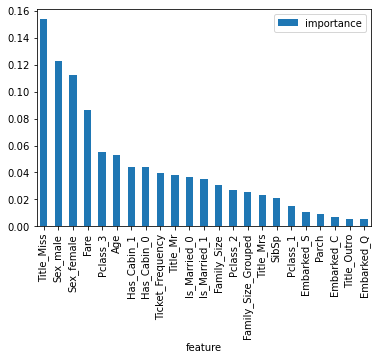

In [172]:
importances.plot.bar()

In [192]:
# Learning curve
def Learning_curve_model(X, Y, model, cv, train_sizes, scoring):

    plt.figure()
    plt.title("Learning curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
    learning_curve(model, X, Y, cv=cv, scoring=scoring, n_jobs=-1,
                   train_sizes=train_sizes, return_times=True)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
                     
    plt.legend(loc="best")
    return plt

In [193]:
train_size = np.linspace(0.5, 1.0, 50)

<module 'matplotlib.pyplot' from 'D:\\Users\\mario\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

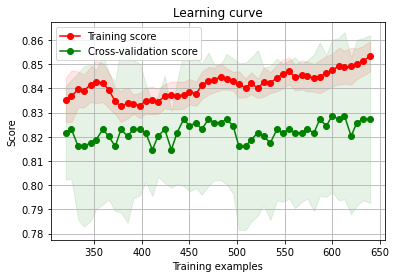

In [199]:
# curva aprendizado para random forest classifier - scoring='accuracy'
scoring='accuracy'
Learning_curve_model(X_train, y_train, rf_best, cv_kfold_stratified, train_size, scoring)

<module 'matplotlib.pyplot' from 'D:\\Users\\mario\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

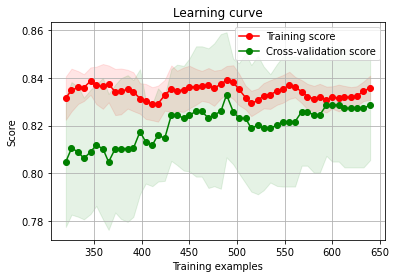

In [198]:
# curva aprendizado para K-n neighbors
scoring='accuracy'
Learning_curve_model(X_train, y_train, knn_best, cv_kfold_stratified, train_size, scoring)

<module 'matplotlib.pyplot' from 'D:\\Users\\mario\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

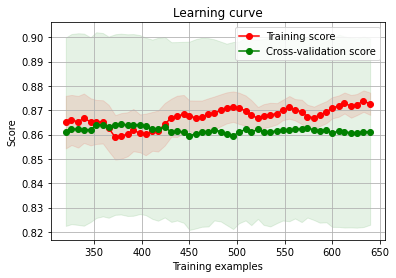

In [197]:
# curva aprendizado para logistic regression
scoring='roc_auc'
Learning_curve_model(X_train, y_train, model_reglog, cv_kfold_stratified, train_size, scoring)

<module 'matplotlib.pyplot' from 'D:\\Users\\mario\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

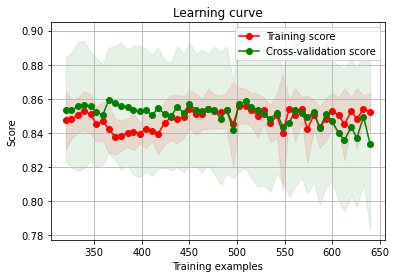

In [196]:
# curva aprendizado para SVM
scoring='roc_auc'
Learning_curve_model(X_train, y_train, svm_best, cv_kfold_stratified, train_size, scoring)

<module 'matplotlib.pyplot' from 'D:\\Users\\mario\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

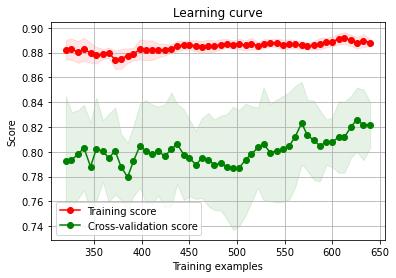

In [195]:
# curva aprendizado para Decision tree
scoring='accuracy'
Learning_curve_model(X_train, y_train, dt_best, cv_kfold_stratified, train_size, scoring)

> melhoria passaria por inclusão de novas features para aumentar a acurácia
> checar se há troca ou conversão de variáveis, na feature importance algumas aparecerão com baixa importância 

# 10. Avaliação do Modelo e escolha do Threshold

Modelo treinado, agora bora avaliar a performance dele. Hora de fazer um predict nos dados de treino e de teste (que separamos no começo, ainda não chegou a hora de utilizarmos o dataset de teste fornecido pela competição).

A métrica da competição é Accuracy, mas nós vimos outras em aula e vale a pena calcular todas elas (Precision, Recall, F-beta, ROC AUC). Além disso, vale testar diferentes thresholds para ver se alterando o threshold observamos aumento da performance do modelo.

Importante nos atentarmos às métricas de treino e teste. Lembrando que quando o modelo performa muito bem no treino e não tão bem no teste, este é um indicativo de overfitting. O modelo "decorou" os dados de treino, aprendendo, inclusive, o ruído e quando recebe dados nunca vistos, não performa bem. Caso as métricas de treino e teste sejam baixas, isto indica underfitting, ou seja, o modelo não é complexo o suficiente para representar, de forma satisfatória, o problema. Podemos tentar adicionar novas variáveis ou utilizar modelos mais complexos (de maior variância).

In [184]:
print('   Random Forest:')
print(20*'-')
print("Score Treino:", round(rf_best.score(X_train, y_train), 4)*100, "%")
print("Score Teste :", round(rf_best.score(X_test, y_test), 4)*100, "%")

   Random Forest:
--------------------
Score Treino: 85.39 %
Score Teste : 82.67999999999999 %


In [185]:
# acurácia média de 83% com desvio padrão de 5% para o dataset de treino
scores = cross_val_score(rf_best, X_train, y_train, cv=10, scoring = "accuracy")
print('DataSet Treino:')
print(15*'-')
print("Scores Treino:", scores)
print("Mean Treino:", round(scores.mean(), 5)*100, "%")
print("Standard Deviation::", round(scores.std(), 5)*100, "%")

DataSet Treino:
---------------
Scores Treino: [0.91666667 0.75       0.78873239 0.83098592 0.84507042 0.77464789
 0.83098592 0.8028169  0.85915493 0.91549296]
Mean Treino: 83.146 %
Standard Deviation:: 5.271 %


In [187]:
# matriz de confusão para o DataSet de treino
# 384 passageiros foram corretamente classificados como não sobreviventes (verdadeiro negativo)
#  55 passageiros foram incorretamente classificados como não sobreviventes (falso positivo)
#  68 passageiros foram incorretamente classificados como sobreviventes (falso negativo)
# 205 passageiros foram corretamente classificados como sobreviventes (verdadeiro positivo)
predictions = cross_val_predict(rf_best, X_train, y_train, cv=3)
confusion_matrix(y_train, predictions)

array([[384,  55],
       [ 68, 205]], dtype=int64)

In [188]:
print("Precision:", precision_score(y_train, predictions))
print("Recall:", recall_score(y_train, predictions))
print("f1_score:", f1_score(y_train, predictions))

Precision: 0.7884615384615384
Recall: 0.7509157509157509
f1_score: 0.7692307692307693


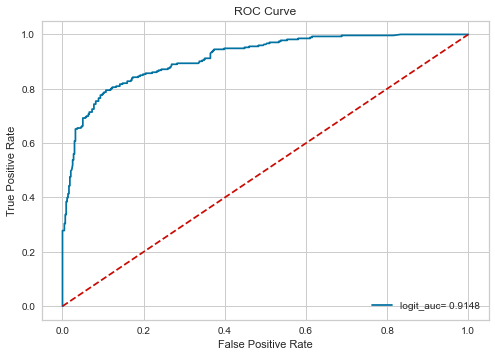

In [208]:
from sklearn.metrics import roc_auc_score
#plot da curva AUC-ROC
y_scores = rf_best.predict_proba(X_train)
y_scores = y_scores[:,1]

fpr,tpr,thresholds = roc_curve(y_train, y_scores)

logit_auc = roc_auc_score(y_train, y_scores)

plt.plot(fpr,tpr,label='logit_auc= %0.4f'%logit_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [191]:
logit_auc = round( roc_auc_score(y_train, y_scores) * 100, 2)
print("O ROC-AUC-Score do modelo Random Forest está em torno de {:.2f} %".format(logit_auc))

O ROC-AUC-Score do modelo Random Forest está em torno de 91.48 %


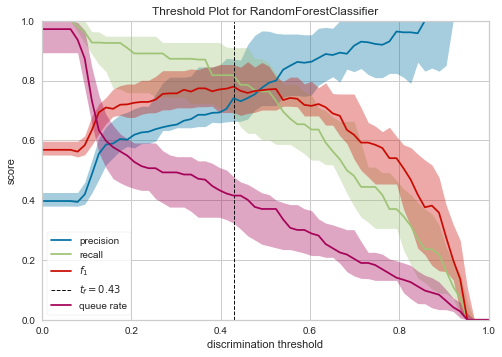

In [201]:
from yellowbrick.classifier import DiscriminationThreshold
visualizer = DiscriminationThreshold(rf_best, cv=cv_kfold_stratified)

visualizer.fit(X_train, y_train)       
visualizer.show()

In [193]:
# Ajuste do threhsold
scores = {}
y_scoretest = rf_best.predict_proba(X_test)[:,1]
for threshold in np.arange(0, 1, 0.01):
    # Calcula classes com base nas probabilidades e no threshold
    y_binario = np.where(y_scoretest > threshold, 1, 0)
    # Mede acuracia
    acuracia = accuracy_score(y_test, y_binario)
    # Armazena threshold e acuracia em dict
    scores[threshold] = acuracia

In [194]:
# Identifica thresold de maior acurácia
max_threshold = max(scores, key=scores.get)
max_threshold

0.51

In [195]:
# Acurácia no teste para maior threshold
test_accuracy = round( scores[max_threshold] * 100, 2)
print("Acurácia no teste para o maior threshold é de {:.2f} %".format(test_accuracy))

Acurácia no teste para o maior threshold é de 83.24 %


# 11. Submissão da solução

Finalmente vamos utilizar o Dataset de teste fornecido pelo Kaggle. Agora é hora de utilizar nosso modelo treinado para fazer um predict sobre esses novos dados e submeter nossa resposta à avaliação da competição (ver no Kaggle o formato correto para submissão).

Caso o resultado obtido não seja satisfatório, voltamos para o passo 4 e tentamos novas ideias para a criação de features! Do contrário, concluímos nosso dessafio!

In [261]:
X_raw_train = df_raw_train.drop('Survived', axis=1)
y_raw_train = df_raw_train['Survived']

# alteração objetos X_final_test
X_raw_train['Embarked'] = X_raw_train['Embarked'].astype('object')
X_raw_train['Parch'] = X_raw_train['Parch'].astype('object')
X_raw_train['Pclass'] = X_raw_train['Pclass'].astype('object')
X_raw_train['Sex'] = X_raw_train['Sex'].astype('object')
X_raw_train['SibSp'] = X_raw_train['SibSp'].astype('object')
X_raw_train['Title'] = X_raw_train['Title'].astype('object')
X_raw_train['Is_Married'] = X_raw_train['Is_Married'].astype('object')
X_raw_train['Family_Size'] = X_raw_train['Family_Size'].astype('object')
X_raw_train['Family_Size_Grouped'] = X_raw_train['Family_Size_Grouped'].astype('object')
X_raw_train['Has_Cabin'] = X_raw_train['Has_Cabin'].astype('object')
X_raw_train['Ticket_Frequency'] = X_raw_train['Ticket_Frequency'].astype('object')

rf_best.fit(X_raw_train, y_raw_train)

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['Age', 'Fare']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Embarked', 'Pclass', 'Sex',
                                                   'Title', 'Is_Married',
                                                   'Has_Cabin']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(categories=[[0,
                                                                              1,
                                                                              2,
                                                                         

In [262]:
# pre_processador.transform(X_final_test)
# prevê modelo
y_pred_rf = rf_best.predict(X_final_test)

In [263]:
# resultado envio
Y_prediction = y_pred_rf.astype('int')

Y_prediction 

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [ ]:
# montando o .csv através do dataframe de submissão
submission = pd.DataFrame({
        "PassengerId": df_final_test["PassengerId"],
        "Survived": Y_prediction
    })

submission.to_csv('submission.csv', index=False)

In [ ]:
# dataframe de submissão
df_my_gender=pd.read_csv("submission.csv")
df_my_gender.sample(5)

In [842]:
df_my_gender.shape

(418, 2)

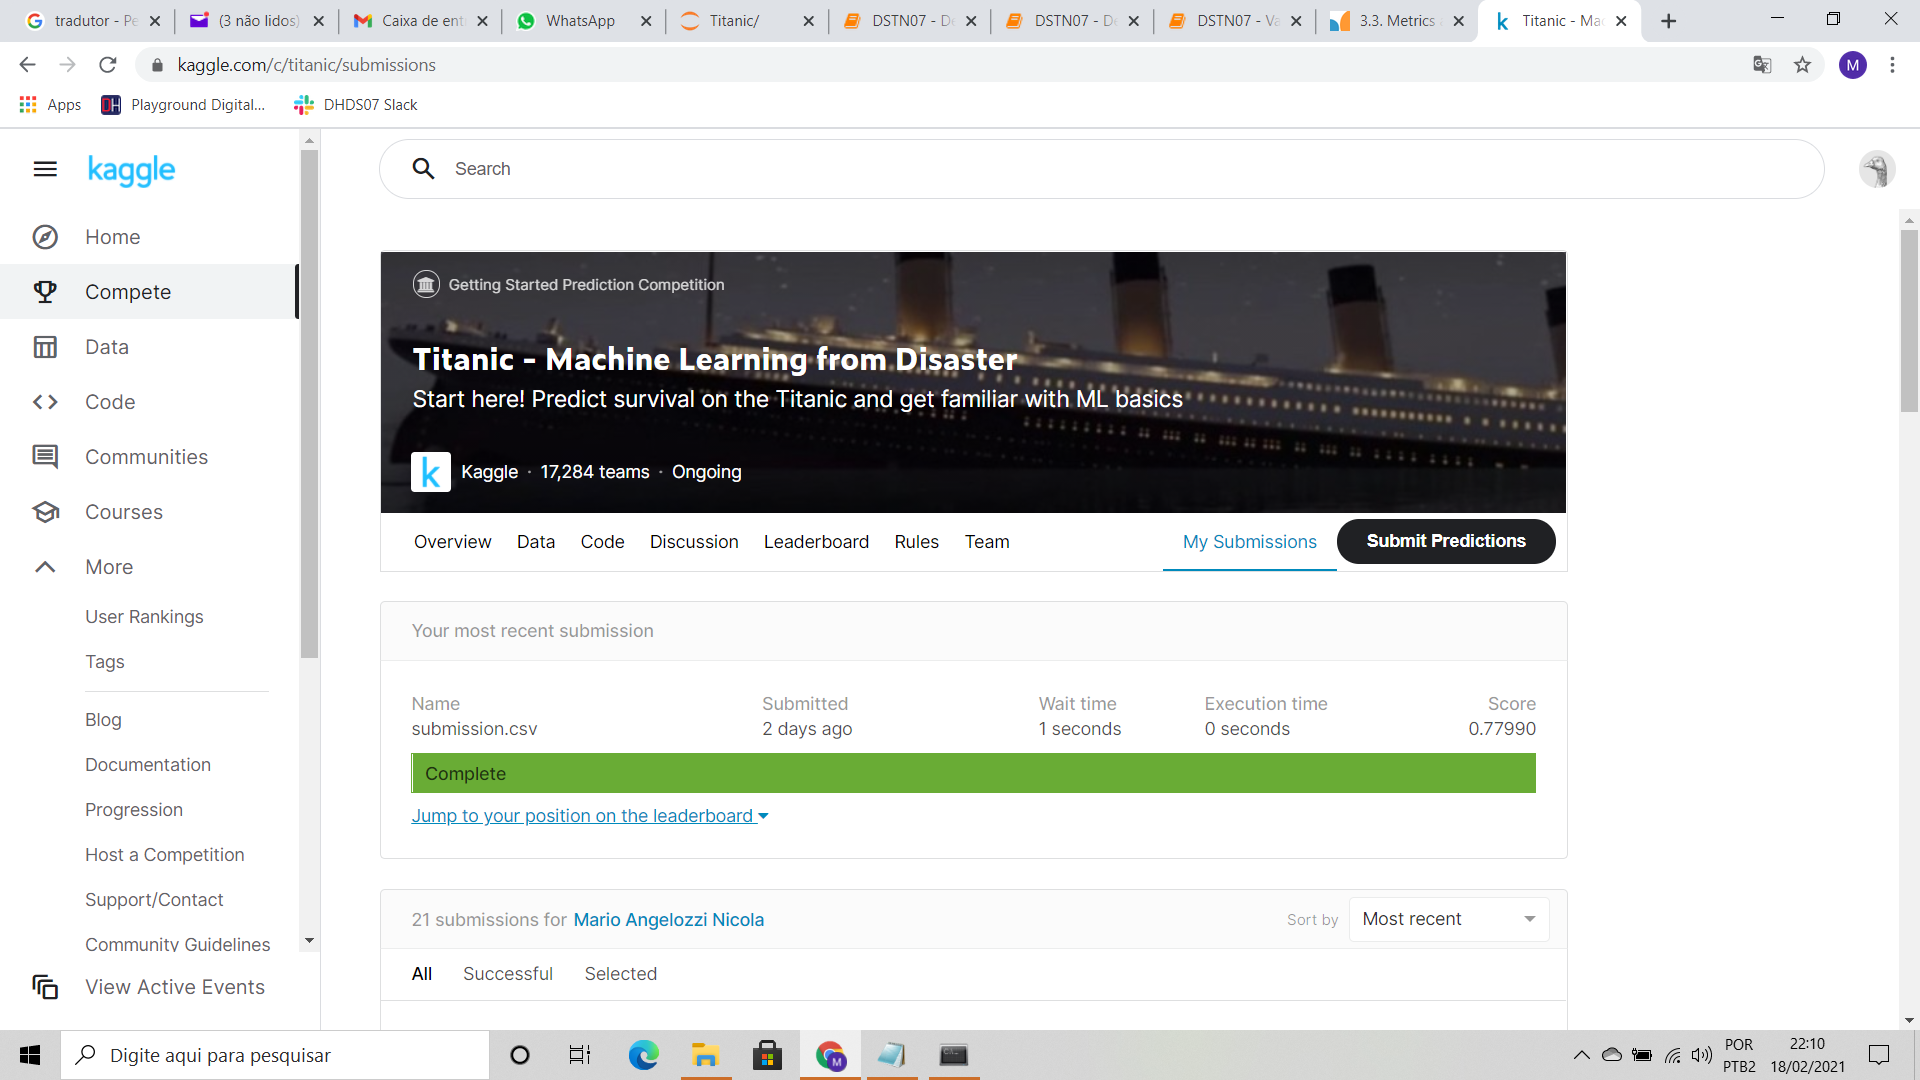